<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/main/model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Stretch tasks:
    - CV
    - best_params_
    - Short list of models
    - sklearn.metrics module

# Imports

In [152]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [153]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

# Grid search
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Setup paths

In [154]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'
df_path = 'ML/Datasets/5.RestaurantRevenue/'

train_path = gdrive_path + df_path + "train.csv"
train_processed_path = gdrive_path + df_path + "trainval_processed.csv"
test_processed_path = gdrive_path + df_path + "test_processed.csv"
test_path =  gdrive_path + df_path + "test.csv"
submission_path = gdrive_path + df_path + "submission.csv"
sample_submission_path = gdrive_path + df_path + "sampleSubmission.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Download the data

In [155]:
df_test = pd.read_csv(test_processed_path, index_col=[0])
df_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-1.032819,-1.653875,0.688913,-1.382555,-0.807152,-0.633614,-2.019553,-0.062452,-0.217343,-0.244523,...,-0.606797,-0.556056,-0.652386,2008.0,0.0,0.0,1.0,0.0,1.134031,14.842280
1,0.015056,0.397991,-0.268140,-1.382555,-0.807152,-0.159426,-0.182156,-0.062452,-0.217343,-0.244523,...,0.655776,0.253599,0.511872,2007.0,0.0,0.0,0.0,1.0,1.769000,15.312391


In [156]:
df_trainval = pd.read_csv(train_processed_path, index_col=[0])
df_trainval.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-0.334236,-0.285964,-1.225193,-0.383325,0.014161,-0.633614,-0.182156,-0.062452,-0.217343,-0.244523,...,0.655776,0.253599,1.094000,2009.0,0.0,0.0,0.0,1.0,2.069,15.278005
1,-0.683527,-0.285964,-1.225193,0.615905,1.656785,0.788952,-0.182156,-0.619713,-0.790338,-0.811816,...,-0.606797,-0.556056,-0.652386,2007.0,1.0,0.0,1.0,0.0,5.663,15.255171


In [157]:
X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

In [158]:
X_test = df_test.values[:, :-1]
Y_test = df_test.values[:, -1]

# Select and train models (+ ensemble methods)

## Preliminary look (shortlisting 2-5 models)

In [159]:
def plot_model_scores(models_dict_, X_, Y_, cv_, scoring_):
    res = {}
    for name, model in models_dict_.items():
        scores = cross_val_score(
            model,
            X_,
            Y_,
            cv=cv_,
            scoring=scoring_
        )
        res[name] = scores
    
    # Sort the dict
    sorted_res = {
        k:v for \
        k, v in sorted(res.items(), key = lambda item: np.mean(item[1]))
    }
    for model_name, scores in sorted_res.items():
        print(f'Model: {model_name}, mean: {np.mean(scores)}, std: {np.std(scores)}')

    return sorted_res

In [160]:
_ = plot_model_scores(
    {
        'RF': RandomForestRegressor(),
        'LinReg': LinearRegression(),
        'Tree': DecisionTreeRegressor(),
        'Lasso': Lasso(),
        'SVM': SVR(),
        'Elastic': ElasticNet()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error'
)

Model: Tree, mean: -0.3047313089602115, std: 0.09218590990237129
Model: LinReg, mean: -0.3002927795320557, std: 0.0841214493207769
Model: SVM, mean: -0.23975755066794463, std: 0.10254520924351965
Model: Lasso, mean: -0.2331971333481854, std: 0.101789341582441
Model: Elastic, mean: -0.21569093211351922, std: 0.10074172443016455
Model: RF, mean: -0.19075931944272975, std: 0.06337403809953175


In [161]:
from dataclasses import dataclass, field

@dataclass
class Model:
    model: None
    name: str
    grid_search_param_grid: list 
    random_search_param_grid: list

In [162]:
RFModel = Model(
    RandomForestRegressor(),
    'RF',
    [
        {'n_estimators': [100, 200, 500]}
    ],

    [
        {
            'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
            'max_depth': [i for i in range(1, 20)]
        }
    ]
)

ElasticNetModel = Model(
    ElasticNet(),
    'Elastic',
    [
        {
            'alpha': [0.1, 0.3, 0.5],
            'l1_ratio': [0.2, 0.4]
        }, 
    ],
    [
        {}
    ]
)

In [163]:
shortlisted_models = {
    model.name: model for model in [RFModel, ElasticNetModel]
}

# Fine tuning

## Grid search

In [164]:
def fit_grid_search(models_dict_, X_, Y_, cv_, scoring_):
    res = {
        name: None for name in list(models_dict_.keys())
    }

    for name, model in models_dict_.items():
        print(f'Fitting {name}')
        
        grid_search_estimator = GridSearchCV(
            model.model,
            param_grid=model.grid_search_param_grid,
            cv=cv_,
            scoring=scoring_,
            return_train_score=True,
            refit=True
        )

        grid_search_result = grid_search_estimator.fit(X_, Y_)
        res[name] = grid_search_result
    return res

In [178]:
from sklearn.model_selection import RandomizedSearchCV

def fit_randomized_search(models_dict_, X_, Y_, cv_, n_iter_, scoring_):
    RANDOM_STATE=42
    res = {}
    for name, model in models_dict_.items():
        print(f'Fitting {name}')

        estimator = RandomizedSearchCV(
            model.model,
            param_distributions = model.random_search_param_grid,
            cv=cv_,
            n_iter=n_iter_,
            scoring = scoring_,
            return_train_score=True,
            refit=True,
            random_state=RANDOM_STATE
        )

        rand_search_res = estimator.fit(X_, Y_)
        res[name] = rand_search_res
    return res

In [166]:
grid_search_results = fit_grid_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_ = 5,
    scoring_ = 'neg_mean_squared_error'
)

Fitting RF
Fitting Elastic


In [167]:
print(grid_search_results['RF'].best_params_)
print(grid_search_results['Elastic'].best_estimator_)

{'n_estimators': 100}
ElasticNet(alpha=0.5, l1_ratio=0.2)


## Randomized search

In [179]:
rand_search_results = fit_randomized_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    n_iter_=10,
    scoring_='neg_mean_squared_error'
)

Fitting RF
Fitting Elastic


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [180]:
rand_search_results['RF'].best_estimator_

RandomForestRegressor(max_depth=17, n_estimators=800)

# Model mistake analysis

- From feature importance analysis, we see that the most important features are **opening year** and **city population**

## Feature importances

<BarContainer object of 43 artists>

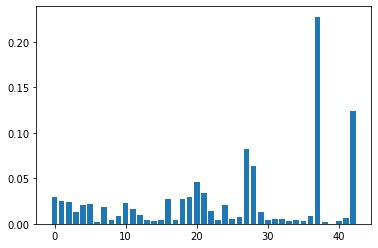

In [181]:
plt.bar(
    np.arange(len(grid_search_results['RF'].best_estimator_.feature_importances_)),
    grid_search_results['RF'].best_estimator_.feature_importances_
)

# CHECK FOR OVERFITTING WITH CROSS_VALIDATE() FUNCTION!

## Visualize predictions

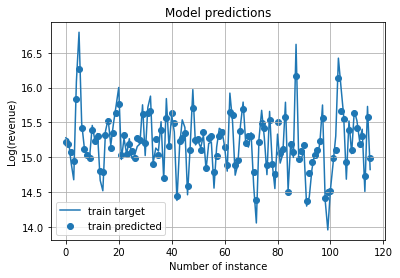

In [196]:
_, ax = plt.subplots()

model = rand_search_results['RF'].best_estimator_
target_X = X_train_val
target_Y = Y_train_val

predictions = model.predict(target_X)


ax.scatter(x=range(len(predictions)), y=predictions, label='train predicted')
ax.plot(target_Y, label='train target')
ax.set_xlabel('Number of instance')
ax.set_ylabel('Log(revenue)')
ax.set_title('Model predictions')

ax.legend()
ax.grid()

In [182]:
rand_search_results['RF'].best_params_

{'n_estimators': 800, 'max_depth': 17}

In [183]:
rand_search_results['RF'].best_estimator_.predict(X_train_val)

array([15.21804706, 15.18887278, 15.06972625, 14.95019149, 15.82990488,
       16.27055515, 15.41700227, 15.11208169, 15.03114269, 14.98710003,
       15.39577771, 15.23403505, 15.30664066, 14.8061646 , 14.78172791,
       15.32173056, 15.51612767, 15.13911853, 15.35015615, 15.63736263,
       15.76082165, 15.03830205, 15.3129717 , 15.04614186, 15.19123198,
       15.08306884, 14.98686907, 15.28188177, 15.24134022, 15.62338555,
       15.19878785, 15.62855958, 15.66979389, 14.90108683, 15.26384068,
       15.02933826, 15.39301063, 14.70381924, 15.56613495, 15.15396917,
       15.63113037, 15.48796261, 14.44032359, 15.23214086, 15.2775924 ,
       15.3452178 , 14.58432414, 15.10152776, 15.70752047, 15.24035621,
       15.26431192, 15.10329711, 15.36802302, 14.84574672, 15.27618952,
       15.30726404, 14.78645098, 15.02231405, 15.30358238, 15.36153432,
       15.14676828, 14.88573621, 15.65269042, 15.60874134, 14.88834071,
       14.95612548, 15.37773415, 15.69792142, 15.20091928, 15.30

# Saving best models (pickle)